# Murdering Cheryl
### How to generate and solve logical deduction problems

You might be familiar with [Cheryl's Birthday](https://en.wikipedia.org/wiki/Cheryl's_Birthday), a mathematical brainteaser that went viral in 2015.

Here's the text of the brainteaser:

> Albert and Bernard just became friends with Cheryl, and they want to know when her birthday is. Cheryl gives them a list of 10 possible dates:
    
>     May     15  16  19
>     June    17  18
>     July    14  16
>     August  14  15  17

> Cheryl then tells Albert and Bernard separately the month and the day of her birthday respectively.

> **Albert:**  I don't know when Cheryl's birthday is, but I know that Bernard doesn't know too.

> **Bernard:**  At first I didn't know when Cheryl's birthday is, but I know now.

> **Albert:**  Then I also know when Cheryl's birthday is.

> So, when is Cheryl's birthday?

It is possible to arrive at the solution by systematically eliminating all but one of the possible dates using the information Albert and Bernard have provided.

One of the difficult things about this problem is that it requires you to maintain a mental model about what each person does and doesn't know (as well as what he could and couldn't know) at any point in time.

In this post, I'm going to present a new twist on the Cheryl's Birthday problem: a murder mystery.

First, I'll give you the problem so you can try to solve it yourself.  Next, I'll describe how I used code to generate the problem.  Then, I'll show you how I used code to solve the problem.  Finally, I'll offer some statistics about how often the generated puzzles result in interesting (or solvable) scenarios.


## Cheryl's Murder

When Cheryl grew up, she became a remarkably successful venture capitalist.  To celebrate her 40th birthday, she invited 13 of her closest friends to spend the weekend at her beachfront mansion.  Saturday evening, while her guests were partying on the first floor, Cheryl excused herself and walked to her room on the second floor.  A few minutes later, her three maids, who were in different rooms upstairs, each heard Cheryl scream.

The first maid, Zoey, got to Cheryl's room and found Cheryl on the floor, stabbed in the stomach.  Cheryl whispered a name to her, and then Zoey ran to get help.  The second maid, Yvonne, ran into the room next and found Cheryl.  Cheryl whispered something to her -- an article of clothing -- and then Yvonne, too, ran to get help.  Finally, the third maid, Ximena, ran into the room.  To Ximena, Cheryl was able to whisper one final word -- an occupation -- and then she breathed her last.

An hour later, Detective Kenneth Kong arrived at the mansion and interviewed the three maids.  They explained that Cheryl had whispered a word to each of them, and it appeared that the words pointed to the party guest who stabbed her.

Here is the list of guests who attended Cheryl's birthday party:

* Albert, a dancer, who wore a ball cap
* Albert, an artist, who wore a ball cap
* Albert, an engineer, who wore an earring
* Bernard, a bricklayer, who wore a ball cap
* Bernard, an artist, who wore cuff links
* Bernard, a dancer, who wore dungarees
* Charles, a dancer, who wore an earring
* Charles, a chef, who wore an ascot
* Daniel, an engineer, who wore an ascot
* Daniel, an artist, who wore an ascot
* Daniel, a bricklayer, who wore an ascot
* Daniel, an artist, who wore cuff links
* Edward, an engineer, who wore an earring

And here is the transcript of Detective Kong's interview with the three maids:

> **Detective:**  So ... what can you tell me? 

> **Zoey**:  I don't know who did it.

> **Yyvonne**:  I don't know who did it.

> **Ximena**:  I don't know who did it.

> **Zoey:**  I still don't know who did it.

> **Yyvonne:**  I still don't know who did it.

> **Ximena**:  I still don't know who did it.

> **Zoey:**  I still don't know who did it.

> **Yyvonne:**  I know who did it!

> **Ximena:**  I know who did it!

> **Zoey:**  I know who did it!

Detective Kong didn't wait for them to tell him the name of the person they suspected.  He raced into the ballroom, where the 13 party guests were gathered, and arrested the culprit.

So ... whom did the detective arrest?

## Generating the guest list

We've got five different names, five articles of clothing, and five occupations.  That's 125 possibilities.  But it's probably overkill to use all 125.  It should be sufficient for our purposes to use about a tenth of them.

Here's some code that will construct a guest list of roughly a dozen people with various combinations of the three attributes.  It will then randomly select one of the people from the list to be the guilty party.

In [116]:
from __future__ import division
import matplotlib.pyplot as plt
from collections import defaultdict 
import pandas as pd
import numpy as np

pd.set_option('display.notebook_repr_html', True)

In [117]:
# for reproducibility
SEED = 754687
np.random.seed(SEED)


# Designate various possible attributes the suspects might have
attributes = [
      {'key': 'name', 'values': ['Albert', 'Bernard', 'Charles', 'Daniel', 'Edward'] },
      {'key': 'clothing', 'values': ['Ascot', 'Ballcap', 'Cuff links', 'Dungarees', 'Earring'] },
      {'key': 'occupation', 'values': ['Artist', 'Bricklayer', 'Chef', 'Dancer', 'Engineer'] },    
]


def get_suspects_dataframe(suspects=False):
    """
    Construct a list of suspects.  If the size of the attribute with the most values is N,
    then the list length will be roughly N multipled by a random number between 1 and N-1.
    """

    if not suspects:
        # Sort the attributes so that the attribute with the most values is first.
        attributes.sort(key=lambda x: len(x['values']), reverse=True)

        # Construct the list of suspects by choosing one value from each attribute.
        largest_len = len(attributes[0]['values'])
        suspects = [{attr['key']: np.random.choice(attr['values']) for attr in attributes}
                    for _ in range(largest_len * np.random.randint(1, largest_len))]
                                                          
    # Create a dataframe from the suspects list, eliminating duplicates
    df = pd.DataFrame(suspects)
    df = df.drop_duplicates()
    return df
         
    
def get_guilty_attributes(df):
    """
    Randomly select the guilty person.
    """
    guilty = np.random.choice(df.index)
    guilty_attributes = df.ix[guilty].to_dict()
    return guilty_attributes


df = get_suspects_dataframe()
df = df.sort_values(by=['name', 'clothing'], ascending=[True, True])
df = df.reset_index(drop=True)
guilty_attributes = get_guilty_attributes(df) # let's not reveal this yet
df

,clothing,name,occupation
0,Ascot,Albert,Dancer
1,Dungarees,Albert,Engineer
2,Earring,Albert,Chef
3,Cuff links,Bernard,Bricklayer
4,Cuff links,Bernard,Artist
5,Earring,Bernard,Bricklayer
6,Ascot,Charles,Engineer
7,Ascot,Charles,Dancer
8,Ballcap,Charles,Dancer
9,Ballcap,Edward,Bricklayer


## Solving the puzzle

We need to be able to keep track of what each of the three maids knows at any given time.

The code below constructs a `confidants` object that maintains what they know about the suspects.

Specifically, for each attribute (name, clothing, and occupation), we maintain what each maid thinks are the possible values they could be.  At the start, each maid knows for certain one of the attributes -- Zoey knows the name, Yvonne knows the clothing, and Ximena knows the occupation -- but they may recognize that several values are possible for each of the other attributes.

When a maid has whittled down the possibilities so that all three attributes have only one possible value, she has solved the mystery and knows the identity of the murderer.


In [118]:
confidant_names = ['Zoey', 'Yvonne', 'Ximena']

# The confidants object keeps track of what each confidant knows about
# the possible suspects.  For each confidant, we track which values
# that confidant considers viable possibilities for each attribute.
confidants = {}

def knows_guilty(confidant):
    """
    Returns whether the given confidant knows who the guilty party is.
    """
    for attr in attributes:
        attr_name = attr['key']
        if len(confidant[attr_name]) > 1:
            return False
    return True
 
def initialize_confidants(df, guilty_attributes):
    """
    Each confidant knows one attribute associated with the guilty party,
    but does not necessarily know any others.  We establish what each
    confidant knows about each attribute as a list of possible values.
    """
    
    for index, attribute in enumerate(attributes):
        confidant_name = confidant_names[index]
        confidants[confidant_name] = {}
        confidant = confidants[confidant_name]
        attribute_name = attribute['key']                               
        for attr in attributes:
            attr_name = attr['key']
            if (attribute_name == attr_name):
                # The confidant knows that this attribute is associated with the guilty party.
                confidant[attr_name] = [guilty_attributes[attr_name]]
            else:
                # The list of possible values for this attribute, given what the confidant knows.
                # At the start, she knows it could be any of the values associated with the
                # guilty attribute she does know.  So, if she knows the guilty person's name is
                # Bernard, and that there were three Bernards present, one who wore a Ballcap
                # and two who wore Dungarees, then the confidant's list of clothing possibilities
                # is two: ['Ballcap', 'Dungarees'].
                confidant[attr_name] = df.loc[df[attribute_name] == guilty_attributes[attribute_name]][attr_name].drop_duplicates().values.tolist()

    # Add a 'knows_guilty' row to the dataframe
    for confidant_name in confidants:
        confidant = confidants[confidant_name]
        # It's possible, but not especially likely, that a confidant knows
        # the guilty party right from the start.  For instance, if there's
        # only one person at the party named Edward, and the confidant knows
        # the guilty party is named Edward, then she knows his identity.
        confidant['knows_guilty'] = knows_guilty(confidant)
    
initialize_confidants(df, guilty_attributes)    

confidants_df = pd.DataFrame(confidants)
confidants_df

,Ximena,Yvonne,Zoey
clothing,"[Dungarees, Ascot]",[Ascot],"[Ascot, Ballcap]"
knows_guilty,False,False,False
name,"[Albert, Charles]","[Albert, Charles]",[Charles]
occupation,[Engineer],"[Dancer, Engineer]","[Engineer, Dancer]"


## Generating the transcript

Now, we iterate over the maids, giving each a turn to say whether she knows who the murderer is.

The maids are able to rely on what was said previously to make inferences.


In [119]:
def generate_transcript(df, **kwargs):
    """
    Print a transcript of the maids' conversation.
    """
    
    iterations = 0
    solved_in = 0
    
    # The confidants now take turns declaring whether they know
    # who the guilty party is.  On the basis of what previous
    # confidants have disclosed, they are able to whittle down
    # the suspects.
    while iterations < 15:
        iterations += 1
        current_name, current_index, current_attribute, current_confidant = get_current_state(iterations)
        print "{} (who knows the guilty person's {}) says:".format(current_name, current_attribute)
        df, report = generate_statements(df, iterations, kwargs)
        if report.iloc[0]['solved_in']:
            break
    return df, report
      
    
def get_current_state(iterations):
    """
    Get the current state as we cycle through the maids.
    """
    current_name = confidant_names[iterations % len(confidant_names) - 1]
    current_index = confidant_names.index(current_name)
    current_attribute = attributes[current_index]['key']
    current_confidant = confidants[current_name]
    return current_name, current_index, current_attribute, current_confidant        
        
                                        
def generate_statements(df, iterations, kwargs=None): 
    """
    Generate the statements a maid makes while it's her turn to talk.
    """

    current_name, current_index, current_attribute, current_confidant = get_current_state(iterations)            

    if not current_confidant['knows_guilty']:
        confidant_attributes = defaultdict(lambda: False)

        # We'll get to this later.
        df, current_confidant = set_could_know_guilty(df, iterations)

        # Whittle down the suspects list based on the information the other maids have shared.
        df, confidant_attributes = evaluate_claims(df, iterations, confidant_attributes)

        # We can now update what this confidant knows about
        # each attribute's possible values.
        current_confidant = update_attributes(df, iterations, confidant_attributes)

    if knows_guilty(current_confidant):
        current_confidant['knows_guilty'] = True
        print '    I know who did it!'
    else:
        current_confidant['knows_guilty'] = False
        print "    I don't know who did it."

        # We'll talk about this part later.
        check_could_know_guilty = kwargs.get('check_could_know_guilty', None)
        if check_could_know_guilty:
            check_could_know_guilty(df, confidants, current_name, current_index, current_attribute)

    num_knows_guilty = [True for confidant_name in confidants if knows_guilty(confidants[confidant_name])]
    if len(num_knows_guilty) == len(confidants):
        # Everybody has figured out the guilty party,
        # so no need to iterate further.
        # assert current_confidant[attr_name][0] == guilty_attributes[attr_name]
        solved_in = iterations        
        return df, pd.DataFrame({'solved_in': solved_in, 'num_knows_guilty': len(num_knows_guilty)}, index=[0])
    
    return df, pd.DataFrame({'solved_in': None, 'num_knows_guilty': len(num_knows_guilty)}, index=[0])
    

def set_could_know_guilty(df, iterations):
    """
    Determine whether the confidant could know the guilty party.
    """
    current_name, current_index, current_attribute, current_confidant = get_current_state(iterations)
    
    if 'could_know_guilty' in current_confidant and current_confidant['could_know_guilty'] == False and len(df) > 2:
        discards = df.groupby(current_attribute)[current_attribute].transform(len) == 1
        discard_rows = df[discards]
        prev_attribute = attributes[current_index - 1]['key']
        attr_matches = discard_rows[prev_attribute].drop_duplicates().values.tolist()
        keep_attr = ~df[prev_attribute].isin(attr_matches)
        keep_attr_rows = df[keep_attr]
        if len(keep_attr_rows):
            df = keep_attr_rows
            current_confidant['could_know_guilty'] == None
    return df, current_confidant
       
    
def evaluate_claims(df, iterations, confidant_attributes):
    """
    Use the information the other maids have shared to whittle down the suspects list.
    """
    
    current_name, current_index, current_attribute, current_confidant = get_current_state(iterations)

    for confidant_name in confidants:
        confidant_index = confidant_names.index(confidant_name)
        if confidant_name != current_name and iterations > confidant_index:
            # We only want to evaluate the claims of the confidant who immediately
            # preceded this one, because the claims of other confidants may not
            # have had access to the knowledge the preceding confidant had.
            confidant_attribute = attributes[confidant_index]['key']
            if confidant_names[confidant_index] == confidant_names[current_index - 1] and len(df) > 2 and \
                len(df) != len(df[df.groupby(confidant_attribute)[confidant_attribute].transform(len) > 1]):
                                   
                    df, confidant_attributes = print_reasoning(
                        df, iterations, confidant_attributes, confidant_name, confidant_attribute)
                    
    return df, confidant_attributes


def print_reasoning(df, iterations, confidant_attributes, confidant_name, confidant_attribute):
    """
    Output the maid's reasoning.
    """

    confidant = confidants[confidant_name]
    
    current_name, current_index, current_attribute, current_confidant = get_current_state(iterations)

    if not confidant['knows_guilty']:
        print "    {} doesn't know who did it.".format(confidant_name)
        keep_rows = df.groupby(confidant_attribute)[confidant_attribute].transform(len) > 1
        discard_rows = df[~keep_rows]
        for index, discard_row in discard_rows.iterrows():
            discard_dict = discard_row.to_dict()
            print "    If {} had been told the {} were {}, {} would know who did it.".format(confidant_name, confidant_attribute, discard_dict[confidant_attribute], confidant_name)
            print "    Therefore, we can eliminate {} from the suspects list.".format("-".join(discard_dict.values()))
        df = df[keep_rows]
    else:
        discard_rows = df.groupby(confidant_attribute)[confidant_attribute].transform(len) > 1
        df = df[~discard_rows]
        possible_rows = df[current_attribute].isin(current_confidant[current_attribute])
        df = df[possible_rows]

        confidant_attributes[confidant_attribute] = df[confidant_attribute].values.tolist()
        print "    {} knows who did it.".format(confidant_name)
        for index, guilty_row in df.iterrows():
            guilty_dict = guilty_row.to_dict()  
            print "    If {} knows who did it, there can be only one suspect who matches the {} {} has been given.".format(confidant_name, confidant_attribute, confidant_name)
            print "    There is only one suspect who matches {}.".format(guilty_dict[confidant_attribute])
            print "    That suspect is {}.".format("-".join(guilty_dict.values()))
        if len(df) == 1:
            for attribute in attributes:
                attribute_name = attribute['key']
                confidant_attributes[attribute_name] = guilty_dict[attribute_name]
          
    return df, confidant_attributes

                
def update_attributes(df, iterations, confidant_attributes):
    """
    Update what the current confidant knows about the guilty party's attributes.
    """

    current_name, current_index, current_attribute, current_confidant = get_current_state(iterations)            
    
    for attribute in attributes:     
        attribute_name = attribute['key']
        if len(current_confidant[attribute_name]) > 1:
            if confidant_attributes[attribute_name]:
                if isinstance(confidant_attributes[attribute_name], list):
                    current_confidant[attribute_name] = confidant_attributes[attribute_name]
                else:
                    current_confidant[attribute_name] = [confidant_attributes[attribute_name]]
            else:
                df_guilty = df.loc[df[current_attribute] == guilty_attributes[current_attribute]][attribute_name].drop_duplicates().values.tolist()
                if len(df_guilty):
                    current_confidant[attribute_name] = df_guilty
    return current_confidant
                
    
generate_transcript(df) 

Zoey (who knows the guilty person's name) says:
    I don't know who did it.
Yvonne (who knows the guilty person's clothing) says:
    Zoey doesn't know who did it.
    If Zoey had been told the name were Edward, Zoey would know who did it.
    Therefore, we can eliminate Ballcap-Edward-Bricklayer from the suspects list.
    I don't know who did it.
Ximena (who knows the guilty person's occupation) says:
    Yvonne doesn't know who did it.
    If Yvonne had been told the clothing were Dungarees, Yvonne would know who did it.
    Therefore, we can eliminate Dungarees-Albert-Engineer from the suspects list.
    If Yvonne had been told the clothing were Ballcap, Yvonne would know who did it.
    Therefore, we can eliminate Ballcap-Charles-Dancer from the suspects list.
    I know who did it!
Zoey (who knows the guilty person's name) says:
    Ximena knows who did it.
    If Ximena knows who did it, there can be only one suspect who matches the occupation Ximena has been given.
    There i

(  clothing     name occupation
 6    Ascot  Charles   Engineer,    num_knows_guilty  solved_in
 0                 3          5)

## Results

Sometimes, the generated puzzles don't have a satisfying solution.  The maids are unable to solve the mystery on the basis of what the others have said.

I was curious about how often the puzzles terminate with a solution, and about how long it takes them to terminate.

So below is a script that runs the code above 1,000 times and outputs some statistics about the results.

In [120]:
%%capture

found_guilty = []
full_results = []

def cheryls_murder():
    suspects_df = get_suspects_dataframe()
    guilty_attributes = get_guilty_attributes(suspects_df)    
    confidants = {}   
    initialize_confidants(suspects_df, guilty_attributes)
    df, report = generate_transcript(suspects_df)
    if report.iloc[0]['solved_in']:
        found_guilty.append(report)
    full_results.append(report)

num_iterations = 1000
attempts = [cheryls_murder() for _ in range(num_iterations)]

### Percentage solved

In [121]:
percentage_solved = len(found_guilty) / num_iterations
print 'percentage solved: {}'.format(percentage_solved)

percentage solved: 0.166


### Number of confidants who know who's guilty

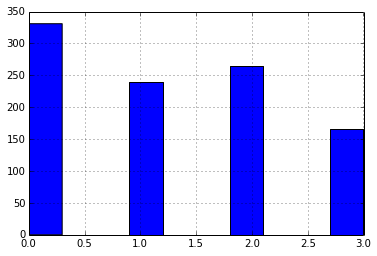

In [122]:
%matplotlib inline

df_guilty = pd.concat(full_results)
df_guilty['num_knows_guilty'].hist()

### Of those that were solved, number of steps it took to solve

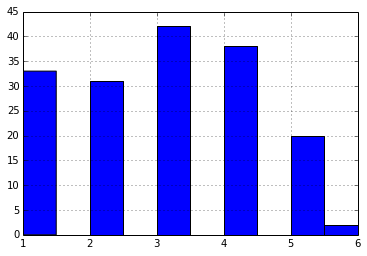

In [123]:
df_guilty.loc[df_guilty['solved_in'] != 0]['solved_in'].hist()

## Cheryl's Birthday

Can the same technique that solves the Cheryl's Murder mystery also solve the original Cheryl's Birthday problem?

Yes, but some modifications are needed.

At the beginning of the Cheryl's Birthday exchange, Albert says that 1) he himself doesn't know her birthday, and 2) Bernard couldn't possibly know her birthday either.  So, he's making a statement not only about what he knows, but also about what he knows that someone else can know.

How does Albert know that Bernard could not know Cheryl's birthday?  It's because he knows the correct month, and each of the day values associated with that month is associated with at least one other month. Thus, no matter what day Bernard has been told, he does not have enough information to figure out the correct month.

To work this into our `generate_transcript` function, we need to first determine whether each of the possible values a fellow confidant might have been given is an ambiguous value -- that is, it is associated with more than one suspect.  If so, we can broadcast the fact that we know that the confidant could not know who the guilty party is.  Then, upon receiving that information, we can work backward and eliminate any suspects whose values don't meet that condition.

We'll broadcast the information by adding a new attribute to each `confidant` object: `could_know_guilty`, which differs from `knows_guilty` because it indicates only the *possibility* that the person knows, not the certainty.


In [124]:
attributes = [
    {'key': 'month', 'values': ['May', 'June', 'July', 'August'] },
    {'key': 'day', 'values': ['14', '15', '16', '17', '18', '19'] },
]

confidant_names = ['Albert', 'Bernard']

suspects = [
    {'month': 'May', 'day': '15'},
    {'month': 'May', 'day': '16'},
    {'month': 'May', 'day': '19'},
    {'month': 'June', 'day': '17'},
    {'month': 'June', 'day': '18'},
    {'month': 'July', 'day': '14'},
    {'month': 'July', 'day': '16'},
    {'month': 'August', 'day': '14'},
    {'month': 'August', 'day': '15'},
    {'month': 'August', 'day': '17'},
]

confidants = {}

df = get_suspects_dataframe(suspects)
guilty_attributes = {'month': 'July', 'day': '16'}
initialize_confidants(df, guilty_attributes)

def check_could_know_guilty(df, confidants, current_name, current_index, current_attribute):
    for confidant_name in confidants:
        confidant_index = confidant_names.index(confidant_name)
        if confidant_names[confidant_index] == confidant_names[current_index - 1]:
            confidant_attribute = attributes[confidant_index]['key']
            confidant = confidants[confidant_name]
            ambiguous = df[df.groupby(confidant_attribute)[confidant_attribute].transform(len) > 1]
            if len(ambiguous):
                confidant_possible_values = ambiguous[confidant_attribute].drop_duplicates().values.tolist()
                possible_values = confidants[current_name][confidant_attribute]
                if set(possible_values).issubset(set(confidant_possible_values)):
                    confidant['could_know_guilty'] = False
                    print '    For all possible values that {} could be, there is more than one possible suspect.'.format(confidant_attribute)
                    print '    Therefore, {} does not know who did it, either.'.format(confidant_name)

                    
generate_transcript(df, **{'check_could_know_guilty': check_could_know_guilty})


Albert (who knows the guilty person's month) says:
    I don't know who did it.
    For all possible values that day could be, there is more than one possible suspect.
    Therefore, Bernard does not know who did it, either.
Bernard (who knows the guilty person's day) says:
    I know who did it!
Albert (who knows the guilty person's month) says:
    Bernard knows who did it.
    If Bernard knows who did it, there can be only one suspect who matches the day Bernard has been given.
    There is only one suspect who matches 16.
    That suspect is 16-July.
    I know who did it!


(  day month
 6  16  July,    num_knows_guilty  solved_in
 0                 2          3)

## More complex puzzles

It's possible to pass in an expanded attributes list to generate what is potentially a more complex puzzle:

In [125]:
# for reproducibility
# 786464
SEED = 123480
np.random.seed(SEED)

# for i in range(123456, 123556):
#     np.random.seed(i)

attributes = [
      {'key': 'name', 'values': ['Albert', 'Bernard', 'Charles', 'Daniel', 'Edward', 'Francis', 'Gerald'] },
      {'key': 'clothing', 'values': ['Ascot', 'Ballcap', 'Cuff links', 'Dungarees', 'Earring'] },
      {'key': 'occupation', 'values': ['Artist', 'Bricklayer', 'Chef', 'Dancer', 'Engineer', 'Farmer'] },    
      {'key': 'favorite programming language', 'values': ['Assembly', 'BASIC', 'C', 'Dart'] },    
]

df = get_suspects_dataframe()

guilty_attributes = get_guilty_attributes(df)

df

,clothing,favorite programming language,name,occupation
0,Earring,C,Gerald,Dancer
1,Cuff links,C,Gerald,Engineer
2,Ascot,Assembly,Charles,Bricklayer
3,Cuff links,C,Francis,Artist
4,Cuff links,C,Albert,Farmer
5,Cuff links,Assembly,Bernard,Farmer
6,Earring,C,Francis,Bricklayer
7,Earring,BASIC,Francis,Chef
8,Dungarees,C,Daniel,Farmer
9,Ascot,Assembly,Charles,Artist


In [126]:
confidant_names = ['Zoey', 'Yvonne', 'Ximena', 'Wendy'];

confidants = {}

initialize_confidants(df, guilty_attributes)    

confidants_df = pd.DataFrame(confidants)
pd.set_option('display.notebook_repr_html', True)
confidants_df

,Wendy,Ximena,Yvonne,Zoey
clothing,"[Earring, Ascot, Dungarees, Ballcap]",[Ballcap],"[Earring, Ballcap]","[Cuff links, Ascot, Earring, Ballcap]"
favorite programming language,[BASIC],"[BASIC, Dart, Assembly]","[C, BASIC, Assembly]","[Assembly, BASIC, Dart]"
knows_guilty,False,False,False,False
name,"[Francis, Bernard, Albert]","[Albert, Bernard, Edward]","[Gerald, Bernard, Edward]",[Bernard]
occupation,"[Chef, Farmer, Dancer, Bricklayer]","[Chef, Artist, Dancer]",[Dancer],"[Farmer, Chef, Artist, Dancer]"


In [127]:
generate_transcript(df)

Zoey (who knows the guilty person's name) says:
    I don't know who did it.
Yvonne (who knows the guilty person's occupation) says:
    Zoey doesn't know who did it.
    If Zoey had been told the name were Daniel, Zoey would know who did it.
    Therefore, we can eliminate C-Dungarees-Daniel-Farmer from the suspects list.
    If Zoey had been told the name were Edward, Zoey would know who did it.
    Therefore, we can eliminate Assembly-Ballcap-Edward-Dancer from the suspects list.
    I don't know who did it.
Ximena (who knows the guilty person's clothing) says:
    Yvonne doesn't know who did it.
    If Yvonne had been told the occupation were Engineer, Yvonne would know who did it.
    Therefore, we can eliminate C-Cuff links-Gerald-Engineer from the suspects list.
    I don't know who did it.
Wendy (who knows the guilty person's favorite programming language) says:
    Ximena doesn't know who did it.
    If Ximena had been told the clothing were Dungarees, Ximena would know who di

(   clothing favorite programming language     name occupation
 18  Ballcap                         BASIC  Bernard     Dancer,
    num_knows_guilty  solved_in
 0                 4          9)

However, as you might expect, the more attributes and attribute values you use, the less likely the maids will be able to solve the puzzle.

## Final thoughts

This exercise was born out of a Hack Days project at [Monetate](http://www.monetate.com).  Twice a year, all of the software engineers at our company are given several days to work on a project of their choosing.  It's a great way for us to try out new technologies and strengthen our programming chops.  [Learn more about working at Monetate](http://www.monetate.com/about/careers/)

The code above uses two means of deduction to narrow down the suspects list.

The first assumes that if a confidant has stated that she does not know who the murderer is, we can rule out any of the remaining suspects who is the only person to have an attribute that the confidant knows about, because otherwise the confidant would be able to determine the murderer's identity based on that information, and thus would not have said that she does not know who the murderer is.

The second method is sort of the inverse of the first.  It assumes that if a confidant has stated that she knows who the murderer is, then only the remaining suspects who are the only ones to have an attribute that the confidant knows about could be the murderer, and we can rule out everybody else.

There may very well be other methods to rule out certain suspects; if you know of any, I'd be interested to learn about them (and perhaps incorporate them into my puzzle-solving script).

By the way, in case you're wondering about the example puzzle that I used above to introduce the Cheryl's Murder mystery, the guest whom Detective Kong arrested was Bernard, a bricklayer, who wore a ball cap.

Check out the transcript below to see how his identity was deduced.


In [128]:
attributes = [
      {'key': 'name', 'values': ['Albert', 'Bernard', 'Charles', 'Daniel', 'Edward'] },
      {'key': 'clothing', 'values': ['Ascot', 'Ballcap', 'Cuff links', 'Dungarees', 'Earring'] },
      {'key': 'occupation', 'values': ['Artist', 'Bricklayer', 'Chef', 'Dancer', 'Engineer'] },    
]

suspects = [{'clothing': 'Ballcap', 'name': 'Albert', 'occupation': 'Dancer'},
 {'clothing': 'Ballcap', 'name': 'Albert', 'occupation': 'Artist'},
 {'clothing': 'Earring', 'name': 'Albert', 'occupation': 'Engineer'},
 {'clothing': 'Ballcap', 'name': 'Bernard', 'occupation': 'Bricklayer'},
 {'clothing': 'Cuff links', 'name': 'Bernard', 'occupation': 'Artist'},
 {'clothing': 'Dungarees', 'name': 'Bernard', 'occupation': 'Dancer'},
 {'clothing': 'Earring', 'name': 'Charles', 'occupation': 'Dancer'},
 {'clothing': 'Ascot', 'name': 'Charles', 'occupation': 'Chef'},
 {'clothing': 'Ascot', 'name': 'Daniel', 'occupation': 'Engineer'},
 {'clothing': 'Ascot', 'name': 'Daniel', 'occupation': 'Artist'},
 {'clothing': 'Ascot', 'name': 'Daniel', 'occupation': 'Bricklayer'},
 {'clothing': 'Cuff links', 'name': 'Daniel', 'occupation': 'Artist'},
 {'clothing': 'Earring', 'name': 'Edward', 'occupation': 'Engineer'}]

df = get_suspects_dataframe(suspects=suspects)

guilty_attributes = {'clothing': 'Ballcap', 'name': 'Bernard', 'occupation': 'Bricklayer'}

confidant_names = ['Zoey', 'Yvonne', 'Ximena']

confidants = {}

initialize_confidants(df, guilty_attributes)

generate_transcript(df)

Zoey (who knows the guilty person's name) says:
    I don't know who did it.
Yvonne (who knows the guilty person's clothing) says:
    Zoey doesn't know who did it.
    If Zoey had been told the name were Edward, Zoey would know who did it.
    Therefore, we can eliminate Earring-Edward-Engineer from the suspects list.
    I don't know who did it.
Ximena (who knows the guilty person's occupation) says:
    Yvonne doesn't know who did it.
    If Yvonne had been told the clothing were Dungarees, Yvonne would know who did it.
    Therefore, we can eliminate Dungarees-Bernard-Dancer from the suspects list.
    I don't know who did it.
Zoey (who knows the guilty person's name) says:
    Ximena doesn't know who did it.
    If Ximena had been told the occupation were Chef, Ximena would know who did it.
    Therefore, we can eliminate Ascot-Charles-Chef from the suspects list.
    I don't know who did it.
Yvonne (who knows the guilty person's clothing) says:
    Zoey doesn't know who did it.
 

(  clothing     name  occupation
 3  Ballcap  Bernard  Bricklayer,    num_knows_guilty  solved_in
 0                 3         10)

---
*Shaun Gallagher is a software engineer at Monetate.  He's also the author of two nonfiction books, [Experimenting With Babies: 50 Amazing Science Projects You Can Perform on Your Kid](http://www.experimentingwithbabies.com) and [Correlated: Surprising Connections Between Seemingly Unrelated Things](http://www.correlated.org), both published by Penguin Random House and available wherever awesome things are sold.*